# Cancer Drug Response Modeling

### Description :

Drug response for each drug is modeled and evaluated using data from 310 cell-line mutations provided by the GDSC website using five separate modeling techniques. 

These modeling techniques include: Elastic nets, Ridge regression, least absolute shrinkage and selection operator, random forest, and SVM with linear kernels

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Data Importation 

### Loading Data Set 1: GDSC 

Please note that before running the code, you will need all the GDSC files. They can be found on the drive (https://drive.google.com/drive/u/1/folders/11omvpOttkdZZgv_ppbtcCbojkuVR-D61) or directly on the GDSC website.

In [2]:
NB_DRUGS = 10 #number of best drugs to select
SCORE = "LN_IC50" #how the sensitivity of the drug is computed; other option: "AUC" 
SAVE = True #whether to save the final matrix or not

#### Cell populations and labels


File which represents how well each cell population reacted to each drug.



1. How is the drug measured?

      a. IC50: describes the concentration of an inhibitor that results in a half-maximal inhibition of a response (i.e. the concentration that reduces a response to 50% of its maximum). That maximum response being inhibited is due to the action of something else (typically an agonist for the receptor of interest). Maximum IC50 = 8. Minimum IC50 = 0.

      IC50 is obtained by plotting a measure of the cell death rate vs the concentration of the drug. IC50 is expressed as a concentration so the higher the concentration of drug needed to kill the cell line the more resistant that cell line is. If the IC50 is very low then the concentration (or amount) of drug needed to kill the cell line is also very low which means the cell line is more sensitive. Typically you get a S curve or sigmoidal curve. IC50 is the middle point of the sigmoidal curve. The threshold for calling a drug sensitive/resistant changes depending upon the IC50 value and we need to see how the sigmoidal curve behaves.

      d. ActArea: "Sensitivity was assayed by measuring cellular ATP levels as a surrogate for cell number and growth. Raw data were merged with assay metadata, and percent-viability scores were calculated relative to DMSO controls, after which concentration-response curves were fit for percent viability. The areas under percent-viability curves were computed and used as the measure of sensitivity". In one paper, the limit was set to 0.8 SD. Sensitive cell lines were the ones with an activity area at least 0.8 SD above the mean. Resistant cell lines had an activity area at least 0.8 SD below the mean. All other samples were discared.



In [3]:
conversion = pd.read_excel("GDSC_CCLE_conversion.xlsx")[["GDSC1000 cosmic id","GDSC1000 name","CCLE name"]]
conversion.head()

GDSC1000 cosmic id GDSC1000 name                               CCLE name
0              906800           697  697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
1              687452          5637                      5637_URINARY_TRACT
2              924100         22RV1                          22RV1_PROSTATE
3              910924      23132-87                                     NaN
4              687561      42-MG-BA           42MGBA_CENTRAL_NERVOUS_SYSTEM

In [4]:
responses = pd.read_excel("Fitted_dose_response.xlsx")
responses.head()

DATASET_VERSION  IC50_RESULTS_ID  COSMIC_ID CELL_LINE_NAME  DRUG_ID  \
0             17.3                1     683665         MC-CAR        1   
1             17.3             1482     684055            ES3        1   
2             17.3             1791     684057            ES5        1   
3             17.3             2177     684059            ES7        1   
4             17.3             2754     684062          EW-11        1   

   DRUG_NAME PUTATIVE_TARGET  MAX_CONC_MICROMOLAR  MIN_CONC_MICROMOLAR  \
0  Erlotinib            EGFR                  2.0             0.007812   
1  Erlotinib            EGFR                  2.0             0.007812   
2  Erlotinib            EGFR                  2.0             0.007812   
3  Erlotinib            EGFR                  2.0             0.007812   
4  Erlotinib            EGFR                  2.0             0.007812   

    LN_IC50       AUC      RMSE   Z_SCORE  
0  2.453524  0.982610  0.021678 -0.015505  
1  3.376592  0.985169  0.029915  0.779999  
2  3.614664  0.983207  0.031201  0.985170  
3  3.223394  0.984574  0.093857  0.647971  
4  2.486405  0.946034  0.087280  0.012832

In [5]:
#Information about data set 
print("Number of different drugs: ",len(responses["DRUG_NAME"].unique()))
print("Number of different cell lines: ", len(responses["CELL_LINE_NAME"].unique()))
print("Total number of tests: ", len(responses.index))
print("Number of tests and cells per drug compounds:")

response_summary = responses.groupby(["DRUG_NAME"])["CELL_LINE_NAME"].agg(['count','nunique']).sort_values(["count"], ascending = False)
response_summary.rename(index = str, columns = {'count': "Number of tests", "nunique" : 'Number of unique cell populations'}, inplace = True)
display(response_summary)

Number of different drugs:  251
Number of different cell lines:  1065
Total number of tests:  224202
Number of tests and cells per drug compounds:


Number of tests  Number of unique cell populations
DRUG_NAME                                                              
Avagacestat                     1934                               1043
UNC0638                         1930                               1038
AKT inhibitor VIII              1913                                998
JQ1                             1881                               1040
CHIR-99021                      1879                               1040
AZD6482                         1864                               1038
Bicalutamide                    1830                               1034
Afatinib                        1825                                985
PLX-4720                        1824                                985
Olaparib                        1816                                987
Selumetinib                     1802                                988
Pictilisib                      1784                                984
Refametinib                     1774                                981
GSK269962A                      1387                               1012
BMS-536924                      1381                               1007
SN-38                            989                                989
TL-2-105                         980                                980
TAK-715                          980                                980
CP466722                         980                                980
GSK429286A                       980                                980
BMS-345541                       980                                980
Genentech Cpd 10                 980                                980
Ruxolitinib                      979                                979
Idelalisib                       979                                979
ZSTK474                          979                                979
Ispinesib Mesylate               979                                979
BX-912                           978                                978
Enzastaurin                      978                                978
Omipalisib                       977                                977
CP724714                         977                                977
...                              ...                                ...
Pyrimethamine                    428                                428
Entinostat                       427                                427
MG-132                           426                                426
GW843682X                        426                                426
Bortezomib                       426                                426
A-770041                         426                                426
TGX221                           426                                426
Paclitaxel                       426                                426
BMS-509744                       426                                426
A-443654                         425                                425
Sunitinib                        425                                425
CMK                              425                                425
CGP-60474                        425                                425
WZ-1-84                          425                                425
CGP-082996                       425                                425
Z-LLNle-CHO                      425                                425
S-Trityl-L-cysteine              424                                424
BI-2536                          424                                424
WH-4-023                         423                                423
Salubrinal                       423                                423
GNF-2                            423                                423
XMD8-85                          422                                422
Dasatinib                        422                         

In [6]:
#Select drugs

selected_drugs = response_summary.index[:NB_DRUGS].values.tolist() #select the drugs
best_responses = responses[responses["DRUG_NAME"].isin(selected_drugs)] #filter the responses df to keep only the ones of selected drugs
best_responses = pd.merge(left = best_responses, right = conversion, how = 'left', left_on = 'COSMIC_ID', right_on = "GDSC1000 cosmic id") #add the corresponding CCLE names
best_responses = best_responses.drop(labels = ["DATASET_VERSION", "IC50_RESULTS_ID", "PUTATIVE_TARGET","MAX_CONC_MICROMOLAR", "MIN_CONC_MICROMOLAR", "RMSE", "Z_SCORE", "GDSC1000 cosmic id", "GDSC1000 name"], axis = 1)
best_responses.head()

COSMIC_ID CELL_LINE_NAME  DRUG_ID     DRUG_NAME   LN_IC50       AUC  \
0     683665         MC-CAR      150  Bicalutamide  1.922705  0.985136   
1     683667         PFSK-1      150  Bicalutamide  2.736094  0.984795   
2     684052           A673      150  Bicalutamide  2.145978  0.988013   
3     684055            ES3      150  Bicalutamide  2.693776  0.984989   
4     684057            ES5      150  Bicalutamide  2.945234  0.983207   

   CCLE name  
0        NaN  
1        NaN  
2  A673_BONE  
3        NaN  
4        NaN

In [7]:
#Missing elements

print("Number of elements before dropping missing values", len(best_responses.index))
best_responses = best_responses.dropna(axis = 0)
print("Number of elements after dropping missing values", len(best_responses.index))
best_responses.head()

Number of elements before dropping missing values 18696
Number of elements after dropping missing values 7196


COSMIC_ID CELL_LINE_NAME  DRUG_ID     DRUG_NAME   LN_IC50       AUC  \
2      684052           A673      150  Bicalutamide  2.145978  0.988013   
7      684072        SK-ES-1      150  Bicalutamide  2.441425  0.980461   
10     687452           5637      150  Bicalutamide  2.294547  0.989483   
11     687455            RT4      150  Bicalutamide  2.910067  0.987345   
12     687457          SW780      150  Bicalutamide  1.686112  0.959700   

              CCLE name  
2             A673_BONE  
7            SKES1_BONE  
10   5637_URINARY_TRACT  
11    RT4_URINARY_TRACT  
12  SW780_URINARY_TRACT

In [8]:
print('Percentage of Null Values in Each Column:')
for column in best_responses:
    print(column,(best_responses[column].isnull().sum())/len(best_responses)*100)


Percentage of Null Values in Each Column:
COSMIC_ID 0.0
CELL_LINE_NAME 0.0
DRUG_ID 0.0
DRUG_NAME 0.0
LN_IC50 0.0
AUC 0.0
CCLE name 0.0


In [9]:
final_response_matrix = best_responses.pivot_table(index = "CCLE name", columns = "DRUG_NAME", values = SCORE)
if SAVE:
    final_response_matrix.to_csv('final_response_matrix.csv')
final_response_matrix.head()


DRUG_NAME                               AKT inhibitor VIII   AZD6482  \
CCLE name                                                              
22RV1_PROSTATE                                    1.179495  3.191798   
42MGBA_CENTRAL_NERVOUS_SYSTEM                     2.560047  0.914375   
5637_URINARY_TRACT                                2.786479  2.929412   
639V_URINARY_TRACT                                2.761992  0.879081   
697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE            0.104100  1.056752   

DRUG_NAME                               Afatinib  Avagacestat  Bicalutamide  \
CCLE name                                                                     
22RV1_PROSTATE                          3.292738     3.669544      3.946671   
42MGBA_CENTRAL_NERVOUS_SYSTEM           3.222914     4.204779      3.703328   
5637_URINARY_TRACT                      0.755066     4.129942      3.295490   
639V_URINARY_TRACT                      1.705377     4.070210      3.118583   
697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  1.704682     3.337629      2.731476   

DRUG_NAME                               CHIR-99021       JQ1  Olaparib  \
CCLE name                                                                
22RV1_PROSTATE                            3.615210  0.564080  4.378780   
42MGBA_CENTRAL_NERVOUS_SYSTEM             2.902907  1.430843  2.445944   
5637_URINARY_TRACT                        3.352622  0.502312  2.520693   
639V_URINARY_TRACT                        3.304297 -0.583141  2.276665   
697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    1.954022  0.025710  0.910062   

DRUG_NAME                               PLX-4720   UNC0638  
CCLE name                                                   
22RV1_PROSTATE                          4.941684  1.804188  
42MGBA_CENTRAL_NERVOUS_SYSTEM           4.973607  1.815938  
5637_URINARY_TRACT                      3.131749  3.185163  
639V_URINARY_TRACT                      4.210108  3.568516  
697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  2.004732  1.417490

In [10]:
print("Total number of cell populations for each drug:")
display(final_response_matrix.count(axis = 0))

Total number of cell populations for each drug:


DRUG_NAME
AKT inhibitor VIII    372
AZD6482               385
Afatinib              378
Avagacestat           386
Bicalutamide          385
CHIR-99021            386
JQ1                   386
Olaparib              380
PLX-4720              378
UNC0638               385
dtype: int64

In [11]:
print("How many NaN values do we have per drug compound ?")
display(pd.DataFrame(final_response_matrix.isnull().sum(axis = 0)).T)
print("Total number of missing values: ", final_response_matrix.isnull().sum().sum())

How many NaN values do we have per drug compound ?


DRUG_NAME  AKT inhibitor VIII  AZD6482  Afatinib  Avagacestat  Bicalutamide  \
0                          15        2         9            1             2   

DRUG_NAME  CHIR-99021  JQ1  Olaparib  PLX-4720  UNC0638  
0                   1    1         7         9        2

Total number of missing values:  49


## Loading Data Set 2: Mutations


File which represents the presence of mutations in these same cell populations.



0 = mutation is not present

1 = mutation is present



In [12]:
alterations = pd.read_csv("Alterations.txt", sep  = '\t').set_index('Description').transpose()
alterations.head()

Description          PLCH2_mut  UBE4B_mut  ADGRB2_mut  ZSCAN20_mut  SZT2_mut  \
127399_SOFT_TISSUE         1.0        1.0         1.0          1.0       1.0   
22RV1_PROSTATE             1.0        0.0         0.0          0.0       1.0   
A204_SOFT_TISSUE           0.0        0.0         0.0          0.0       0.0   
A253_SALIVARY_GLAND        0.0        0.0         0.0          0.0       0.0   
A427_LUNG                  0.0        0.0         0.0          0.0       0.0   

Description          MOB3C_mut  ZFYVE9_mut  ST6GALNAC3_mut  TCHH_mut  \
127399_SOFT_TISSUE         1.0         1.0             1.0       1.0   
22RV1_PROSTATE             0.0         0.0             0.0       0.0   
A204_SOFT_TISSUE           0.0         0.0             0.0       0.0   
A253_SALIVARY_GLAND        0.0         0.0             0.0       0.0   
A427_LUNG                  0.0         0.0             0.0       0.0   

Description          HRNR_mut    ...     HNRNPDL_del  DMTF1_del  PPP4R1_del  \
127399_SOFT_TISSUE        1.0    ...             0.0        0.0         0.0   
22RV1_PROSTATE            0.0    ...             0.0        0.0         0.0   
A204_SOFT_TISSUE          0.0    ...             0.0        0.0         0.0   
A253_SALIVARY_GLAND       0.0    ...             0.0        0.0         0.0   
A427_LUNG                 0.0    ...             0.0        0.0         0.0   

Description          CDH1_del  SLC12A6_del  PTBP3_del  KCNE2_del  DGCR2_del  \
127399_SOFT_TISSUE        0.0          0.0        0.0        0.0        0.0   
22RV1_PROSTATE            0.0          0.0        0.0        0.0        0.0   
A204_SOFT_TISSUE          0.0          0.0        0.0        0.0        0.0   
A253_SALIVARY_GLAND       0.0          0.0        0.0        0.0        0.0   
A427_LUNG                 0.0          0.0        0.0        0.0        0.0   

Description          CASP8AP2_del  SCO2_del  
127399_SOFT_TISSUE            0.0       0.0  
22RV1_PROSTATE                0.0       0.0  
A204_SOFT_TISSUE              0.0       0.0  
A253_SALIVARY_GLAND           0.0       0.0  
A427_LUNG                     0.0       0.0  

[5 rows x 64144 columns]

## Merging Mutation and Drug Response Data


#### AKT Inhibitor VIII 

In [13]:
drug_name = 'AKT inhibitor VIII'

drug_matrix = alterations.merge(final_response_matrix[[drug_name]], left_index = True, right_index = True).dropna(axis = 0)

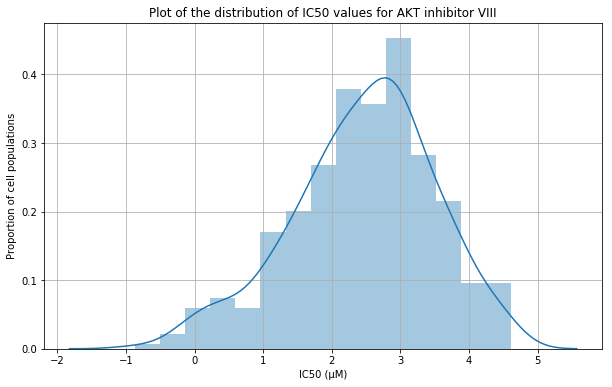

In [14]:
fig = plt.figure(figsize = (10,6))
sns.distplot(drug_matrix[[drug_name]])
plt.title("Plot of the distribution of IC50 values for "+ drug_name)
plt.xlabel("IC50 (µM)")
plt.ylabel("Proportion of cell populations")
plt.grid(True);

In [15]:
drug_matrix.head()

PLCH2_mut  UBE4B_mut  ADGRB2_mut  \
22RV1_PROSTATE                                   1.0        0.0         0.0   
A204_SOFT_TISSUE                                 0.0        0.0         0.0   
A253_SALIVARY_GLAND                              0.0        0.0         0.0   
A673_BONE                                        0.0        1.0         0.0   
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE        0.0        0.0         0.0   

                                           ZSCAN20_mut  SZT2_mut  MOB3C_mut  \
22RV1_PROSTATE                                     0.0       1.0        0.0   
A204_SOFT_TISSUE                                   0.0       0.0        0.0   
A253_SALIVARY_GLAND                                0.0       0.0        0.0   
A673_BONE                                          0.0       0.0        0.0   
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE          0.0       0.0        0.0   

                                           ZFYVE9_mut  ST6GALNAC3_mut  \
22RV1_PROSTATE                                    0.0             0.0   
A204_SOFT_TISSUE                                  0.0             0.0   
A253_SALIVARY_GLAND                               0.0             0.0   
A673_BONE                                         0.0             0.0   
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE         0.0             0.0   

                                           TCHH_mut  HRNR_mut  \
22RV1_PROSTATE                                  0.0       0.0   
A204_SOFT_TISSUE                                0.0       0.0   
A253_SALIVARY_GLAND                             0.0       0.0   
A673_BONE                                       0.0       0.0   
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE       0.0       0.0   

                                                  ...          DMTF1_del  \
22RV1_PROSTATE                                    ...                0.0   
A204_SOFT_TISSUE                                  ...                0.0   
A253_SALIVARY_GLAND                               ...                0.0   
A673_BONE                                         ...                0.0   
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE         ...                0.0   

                                           PPP4R1_del  CDH1_del  SLC12A6_del  \
22RV1_PROSTATE                                    0.0       0.0          0.0   
A204_SOFT_TISSUE                                  0.0       0.0          0.0   
A253_SALIVARY_GLAND                               0.0       0.0          0.0   
A673_BONE                                         0.0       0.0          0.0   
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE         0.0       0.0          0.0   

                                           PTBP3_del  KCNE2_del  DGCR2_del  \
22RV1_PROSTATE                                   0.0        0.0        0.0   
A204_SOFT_TISSUE                                 0.0        0.0        0.0   
A253_SALIVARY_GLAND                              0.0        0.0        0.0   
A673_BONE                                        0.0        0.0        0.0   
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE        0.0        0.0        0.0   

                                           CASP8AP2_del  SCO2_del  \
22RV1_PROSTATE                                      0.0       0.0   
A204_SOFT_TISSUE                                    0.0       0.0   
A253_SALIVARY_GLAND                                 0.0       0.0   
A673_BONE                                           0.0       0.0   
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE           0.0       1.0   

                                           AKT inhibitor VIII  
22RV1_PROSTATE                                       1.179495  
A204_SOFT_TISSUE                                     1.715336  
A253_SALIVARY_GLAND                                  2.300805  
A673_BONE                                            2.505491  
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE            0.272181  

[5 rows x 64145 columns]

In [16]:
drug_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 369 entries, 22RV1_PROSTATE to SKNBE2_AUTONOMIC_GANGLIA
Columns: 64145 entries, PLCH2_mut to AKT inhibitor VIII
dtypes: float64(64145)
memory usage: 180.6+ MB


#### Contextual Feature Selection

There are a number of features that have no mutations across all cell-lines. These features add no importance to our final model which uses mutations as a way to predict response, so they will be dropped from our model.

In [17]:
print('The number of features whose sum is zero and will be dropped: ',(drug_matrix.astype('bool').sum() == 0).sum())
print('The number of features retained is: ',(drug_matrix.astype('bool').sum() != 0).sum())

The number of features whose sum is zero and will be dropped:  24130
The number of features retained is:  40015


In [152]:
pd.set_option('display.max_rows', 50000)
pd.DataFrame(drug_matrix.astype('bool').sum()).sort_values(by = 0)

0
CHMP3_amp                     0
BEND4_amp                     0
GRXCR1_amp                    0
TMPRSS11F_amp                 0
ANXA2R_amp                    0
TEX43_amp                     0
PROB1_amp                     0
C5orf46_amp                   0
SMIM20_amp                    0
ARHGEF37_amp                  0
SFTA2_amp                     0
CLPSL2_amp                    0
C6orf222_amp                  0
GLYATL3_amp                   0
GFRAL_amp                     0
LIN28B_amp                    0
SAMD5_amp                     0
PSMG4_amp                     0
KRT86_amp                     0
TMEM212_amp                   0
LEKR1_amp                     0
PLEKHM3_amp                   0
C2orf80_amp                   0
RESP18_amp                    0
C2orf82_amp                   0
OR6B2_amp                     0
KRT85_amp                     0
ZNF662_amp                    0
CDHR4_amp                     0
FAM212A_amp                   0
IQCF2_amp                     0
IQCF5_amp                     0
MUSTN1_amp                    0
VGLL3_amp                     0
PRR23B_amp                    0
PRR23C_amp                    0
PLSCR5_amp                    0
ANKUB1_amp                    0
IYD_amp                       0
RBAKDN_amp                    0
KTN1_amp                      0
GTF2IRD2B_amp                 0
C9orf172_amp                  0
LRRC26_amp                    0
MYMK_amp                      0
MAP3K15_amp                   0
SPACA5_amp                    0
USP27X_amp                    0
PAGE2B_amp                    0
ZCCHC13_amp                   0
UBE2NL_amp                    0
AFF3_amp                      0
AKR1C6P_amp                   0
C1QL3_amp                     0
ACAT2_amp                     0
RND3_amp                      0
NKX1-2_amp                    0
OR52K1_amp                    0
OR52I1_amp                    0
LCN15_amp                     0
SP5_amp                       0
LAD1_amp                      0
IER5L_amp                     0
LAMTOR4_amp                   0
FAM180A_amp                   0
XKR5_amp                      0
LINC00937_amp                 0
ALKAL1_amp                    0
C8orf87_amp                   0
RBM12B_amp                    0
MROH5_amp                     0
MAFA_amp                      0
L1CAM_amp                     0
SPATA31A6_amp                 0
GLIDR_amp                     0
SPATA31D4_amp                 0
SPATA31D3_amp                 0
SPATA31D1_amp                 0
C9orf153_amp                  0
PTGES2-AS1_amp                0
CFAP77_amp                    0
OR51D1_amp                    0
LINC01120_amp                 0
DPP10-AS1_amp                 0
BHMG1_amp                     0
IGFL3_amp                     0
ZNF808_amp                    0
ZNF761_amp                    0
TMEM238_amp                   0
ZNF470_amp                    0
ZNF749_amp                    0
BLOC1S3_amp                   0
RPL23AP87_amp                 0
HES5_amp                      0
SMIM1_amp                     0
RNF207_amp                    0
TMEM82_amp                    0
TRNP1_amp                     0
CD164L2_amp                   0
TRABD2B_amp                   0
C1QTNF12_amp                  0
CEACAM16_amp                  0
CEACAM22P_amp                 0
ZNF790_amp                    0
C17orf100_amp                 0
SPDYE4_amp                    0
TMEM220_amp                   0
TMIGD1_amp                    0
LINC00671_amp                 0
CCDC103_amp                   0
RPRML_amp                     0
BTBD17_amp                    0
PVALEF_amp                    0
POTEC_amp                     0
LYPLA2P2_amp                  0
C3P1_amp                      0
ZNF788_amp                    0
CLEC17A_amp                   0
CYP4F24P_amp                  0
RGS9BP_amp                    0
KRTDAP_amp                    0
LDLRAD1_amp                   0
GBP7_amp                      0
C1orf146_amp                  0
FAM69A_amp                    

In [18]:
drug_matrix = drug_matrix.iloc[:,list(drug_matrix.astype('bool').sum() != 0)].copy()
drug_matrix.head(20)

PLCH2_mut  UBE4B_mut  ADGRB2_mut  \
22RV1_PROSTATE                                    1.0        0.0         0.0   
A204_SOFT_TISSUE                                  0.0        0.0         0.0   
A253_SALIVARY_GLAND                               0.0        0.0         0.0   
A673_BONE                                         0.0        1.0         0.0   
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE         0.0        0.0         0.0   
CORL23_LUNG                                       0.0        0.0         0.0   
DOV13_OVARY                                       0.0        1.0         0.0   
G401_SOFT_TISSUE                                  0.0        0.0         0.0   
G402_SOFT_TISSUE                                  0.0        0.0         0.0   
HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE        0.0        0.0         0.0   
KYSE140_OESOPHAGUS                                0.0        0.0         0.0   
NCIH1048_LUNG                                     0.0        0.0         0.0   
NCIH1092_LUNG                                     0.0        0.0         1.0   
NCIH1915_LUNG                                     0.0        0.0         0.0   
OCUM1_STOMACH                                     0.0        0.0         0.0   
SAOS2_BONE                                        0.0        0.0         0.0   
SKES1_BONE                                        0.0        0.0         0.0   
TC71_BONE                                         0.0        0.0         0.0   
AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE           0.0        0.0         0.0   
BL41_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE           0.0        0.0         0.0   

                                            ZSCAN20_mut  SZT2_mut  MOB3C_mut  \
22RV1_PROSTATE                                      0.0       1.0        0.0   
A204_SOFT_TISSUE                                    0.0       0.0        0.0   
A253_SALIVARY_GLAND                                 0.0       0.0        0.0   
A673_BONE                                           0.0       0.0        0.0   
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE           0.0       0.0        0.0   
CORL23_LUNG                                         0.0       0.0        0.0   
DOV13_OVARY                                         0.0       0.0        0.0   
G401_SOFT_TISSUE                                    0.0       0.0        0.0   
G402_SOFT_TISSUE                                    0.0       0.0        0.0   
HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE          0.0       0.0        0.0   
KYSE140_OESOPHAGUS                                  0.0       0.0        0.0   
NCIH1048_LUNG                                       0.0       1.0        0.0   
NCIH1092_LUNG                                       0.0       0.0        0.0   
NCIH1915_LUNG                                       0.0       1.0        0.0   
OCUM1_STOMACH                                       0.0       0.0        0.0   
SAOS2_BONE                                          0.0       0.0        0.0   
SKES1_BONE                                          0.0       0.0        0.0   
TC71_BONE                                           0.0       0.0        0.0   
AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE             0.0       1.0        0.0   
BL41_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE             1.0       0.0        0.0   

                                            ZFYVE9_mut  ST6GALNAC3_mut  \
22RV1_PROSTATE                                     0.0             0.0   
A204_SOFT_TISSUE                                   0.0             0.0   
A253_SALIVARY_GLAND                                0.0             0.0   
A673_BONE                                          0.0             0.0   
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE          0.0             0.0   
CORL23_LUNG                                        0.0             0.0   
DOV13_OVARY                                        0.0             0.0   
G401_SOFT_TISSUE                                   0.0             0.0   
G402_SOFT_TISSUE

##### Retaining mutation features

The features include three different types of genetic phenomena: mutations (mut), deletions (del), amplifications (amp). We are testing here to see if correlations exist between any of the features. Separate study indicated that many of the deletions are correlated to amplifications, so we are dropping these features.

In [19]:
features = list(drug_matrix.columns)

mut = []
del_amp = []

for name in features :
    
    if 'mut' in name :
        
        mut.append(name)
    
    else :
        
        del_amp.append(name)
        

In [149]:
print('The number of features labeled as mutations are: ', len(mut))
print('The number of features labeled as deletions or amplifications are: ', len(del_amp))

The number of features labeled as mutations are:  18652
The number of features labeled as deletions or amplifications are:  45493


In [40]:
#X = drug_matrix.loc[:, mut].copy()

X = drug_matrix.copy()
y = drug_matrix.iloc[:, -1].copy()


NB_COMPONENTS = 120
screeplot = True
kf = 5

In [115]:
sc = MinMaxScaler()  #defines the scaler

#X_norm = sc.fit_transform(X)

#### Reduced Variance


In [21]:
# removing the features with a variance of less than 0.1
variance = X.var(axis = 0)
reduced_X = X.loc[:,variance[variance > 0.1].index]

reduced_X.head()

SZT2_mut  TCHH_mut  HRNR_mut  \
22RV1_PROSTATE                                  1.0       0.0       0.0   
A204_SOFT_TISSUE                                0.0       0.0       0.0   
A253_SALIVARY_GLAND                             0.0       0.0       0.0   
A673_BONE                                       0.0       0.0       0.0   
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE       0.0       0.0       0.0   

                                           FLG2_mut  BAZ2B_mut  SCN9A_mut  \
22RV1_PROSTATE                                  0.0        0.0        0.0   
A204_SOFT_TISSUE                                0.0        0.0        0.0   
A253_SALIVARY_GLAND                             0.0        0.0        1.0   
A673_BONE                                       0.0        0.0        0.0   
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE       0.0        0.0        0.0   

                                           ANK2_mut  RP1L1_mut  ABCA2_mut  \
22RV1_PROSTATE                                  1.0        0.0        0.0   
A204_SOFT_TISSUE                                0.0        0.0        0.0   
A253_SALIVARY_GLAND                             0.0        0.0        1.0   
A673_BONE                                       0.0        0.0        0.0   
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE       0.0        0.0        0.0   

                                           EP400_mut         ...          \
22RV1_PROSTATE                                   1.0         ...           
A204_SOFT_TISSUE                                 0.0         ...           
A253_SALIVARY_GLAND                              0.0         ...           
A673_BONE                                        0.0         ...           
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE        0.0         ...           

                                           CNDP1_del  SERPINB7_del  \
22RV1_PROSTATE                                   0.0           0.0   
A204_SOFT_TISSUE                                 0.0           0.0   
A253_SALIVARY_GLAND                              1.0           1.0   
A673_BONE                                        0.0           0.0   
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE        0.0           0.0   

                                           TNFRSF11A_del  SERPINB12_del  \
22RV1_PROSTATE                                       0.0            0.0   
A204_SOFT_TISSUE                                     0.0            0.0   
A253_SALIVARY_GLAND                                  1.0            1.0   
A673_BONE                                            0.0            0.0   
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE            0.0            0.0   

                                           SERPINB11_del  DSEL_del  SOCS6_del  \
22RV1_PROSTATE                                       0.0       0.0        0.0   
A204_SOFT_TISSUE                                     0.0       0.0        0.0   
A253_SALIVARY_GLAND                                  1.0       1.0        1.0   
A673_BONE                                            0.0       0.0        0.0   
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE            0.0       0.0        0.0   

                                           VPS4B_del  ZNF516_del  \
22RV1_PROSTATE                                   0.0         0.0   
A204_SOFT_TISSUE                                 0.0         0.0   
A253_SALIVARY_GLAND                              1.0         1.0   
A673_BONE                                        0.0         0.0   
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE        0.0         0.0   

                                           AKT inhibitor VIII  
22RV1_PROSTATE                                       1.179495  
A204_SOFT_TISSUE                                     1.715336  
A253_SALIVARY_GLAND                                  2.300805  
A673_BONE                                            2.505491  
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE            0.272181  

[5 rows x 451 columns]

In [22]:
reduced_X.shape

(369, 451)

Number of features before PCA:  40014


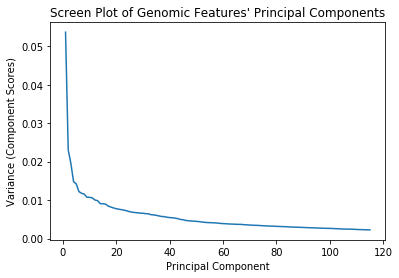

Number of combined features after PCA:  115


PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
0  14.641361 -1.593851 -0.636539 -1.491096  0.176709 -1.028237  1.205972   
1  -2.732118 -2.811375 -0.667078 -0.707133 -0.174930 -0.428337  0.252970   
2  -1.831542  9.330340 -8.620020  7.204653  1.286107 -0.929007  5.382345   
3  -3.191576 -2.739403 -0.530268 -0.721883 -0.068208 -0.442328  0.187942   
4  -3.266655 -2.423013 -0.646791 -0.748423 -0.110022 -0.336442 -0.022103   

        PC7       PC8       PC9    ...        PC105     PC106     PC107  \
0 -2.263573  0.499867 -1.525941    ...     0.188998  0.190138  0.204634   
1  0.344462 -0.200554  0.621447    ...     0.003888  0.050473  0.298585   
2 -1.081123 -3.109916 -0.594873    ...     2.038805  1.400751 -3.521101   
3  0.432862 -0.043005  0.514862    ...     0.209498 -0.408112  0.016507   
4  0.276028  0.830036 -0.095091    ...    -0.018477 -1.287281  0.086688   

      PC108     PC109     PC110     PC111     PC112     PC113     PC114  
0 -0.005767 -0.124152  0.006559  0.117193 -0.192079 -0.411821 -0.106727  
1  0.319816 -0.231870  0.293892 -0.230270  0.323045 -0.323384 -0.022160  
2  2.537054 -3.386382 -4.630196 -1.908589  3.419304 -1.814711 -3.308685  
3  0.021909 -0.301343 -0.165819 -0.176321  0.151382 -0.359524 -0.095468  
4  0.331416 -0.353082 -0.226300  0.169804 -0.138411  0.893224 -0.086175  

[5 rows x 115 columns]

In [41]:
from sklearn.decomposition import PCA

NB_COMPONENTS = 115
screeplot = True
kf = 5

print("Number of features before PCA: ", len(X.columns) - 1)


my_PCA = PCA(n_components=NB_COMPONENTS)
reduced_X = pd.DataFrame(my_PCA.fit_transform(np.array(X.values), y=None))
reduced_X.columns = [f"PC{elem}" for elem in range(NB_COMPONENTS)]

if screeplot:
    fig = plt.figure()
    g = sns.lineplot(x = range(1,NB_COMPONENTS+1), y = my_PCA.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance (Component Scores)')
    plt.title('Screen Plot of Genomic Features\' Principal Components')
    plt.show(); 


print("Number of combined features after PCA: ",len(list(reduced_X)))
reduced_X.head()

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso


np.random.seed(0)

#Scaling the features -- useful for most classifier except RF and co        
feature_names = list(reduced_X) #stores the name of features
sc = StandardScaler()  #defines the scaler
reduced_X = pd.DataFrame(sc.fit_transform(reduced_X)) #scales the data
reduced_X.columns = feature_names 

from sklearn.linear_model import LinearRegression

np.random.seed(0)

lr = LinearRegression()
lr_scores = cross_val_score(lr,reduced_X, y, cv=kf)  # fit + predict + eval.
print('SVM Average Accuracy:', str(round(lr_scores.mean()*100,3)),'%')
print('SD:', 100*np.std(lr_scores))

SVM Average Accuracy: -1701.959 %
SD: 1100.208032717949


In [43]:
np.random.seed(0)

#Scaling the features -- useful for most classifier except RF and co        
feature_names = list(reduced_X) #stores the name of features
sc = StandardScaler()  #defines the scaler
reduced_X = pd.DataFrame(sc.fit_transform(reduced_X)) #scales the data
reduced_X.columns = feature_names 

np.random.seed(0)

lasso = Lasso(alpha = 0.05)
lasso_scores = cross_val_score(lasso,reduced_X, y, cv=kf)  # fit + predict + eval.
print('SVM Average Accuracy:', str(round(lasso_scores.mean()*100,3)),'%')
print('SD:', 100*np.std(lasso_scores))

SVM Average Accuracy: 31.172 %
SD: 9.002012696691947


In [198]:
# Import necessary modules
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.010, normalize=False)

# Fit the regressor to the data
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
# Compute and print the coefficients
#lasso_coef = lasso.coef_
#print(lasso_coef)
mse

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Feature Selection Using PCA

In [57]:
from sklearn.decomposition import PCA

In [61]:
NB_COMPONENTS = 150
screeplot = True
kf = 3

#### AKT inhibitor VIII

Number of features before PCA:  18273


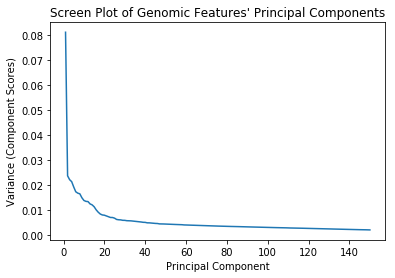

Number of combined features after PCA:  150


PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
0 -2.375474 -0.071681 -0.157859 -0.325186 -0.041354  0.084630 -0.074907   
1 -2.041723 -0.018030 -0.073052  0.149784 -0.002621 -0.290146 -0.180615   
2 -2.737615  0.051155  0.115910 -0.254284 -0.120218  0.015640  0.048726   
3 -1.809399  0.067441  0.181880 -0.249250 -0.295320 -0.065174  0.099561   
4 -2.543591  0.432736 -0.212952 -0.085646 -0.469205 -0.167366  0.090370   

        PC7       PC8       PC9    ...        PC140     PC141     PC142  \
0 -0.119658 -0.386058  0.114189    ...     3.006801  1.958976  0.768865   
1  0.039046 -0.306685 -0.051939    ...    -0.933177  2.621867  2.144053   
2 -0.027627 -0.067748 -0.083319    ...    -0.499834  3.004709  0.997528   
3 -0.243242 -0.263560  0.109252    ...     3.394986  1.538385 -1.485089   
4  0.201825 -0.239765  0.065950    ...     0.388777 -1.623103 -1.013791   

      PC143     PC144     PC145     PC146     PC147     PC148     PC149  
0 -1.620490 -1.093856 -1.432936 -0.022851 -2.053792  1.485280 -1.599115  
1  1.969358 -0.032933  5.165993  0.063203  1.218605  1.367026 -2.115219  
2  0.793945 -0.180668  0.959476  0.706021 -0.222326 -0.846142 -0.420441  
3  0.303004 -1.496605  1.163015  0.901842  0.681060  1.024602  0.660188  
4 -2.510639  0.308824 -2.208466 -1.322383  0.560702  0.092723 -3.099764  

[5 rows x 150 columns]

In [65]:
print("Number of features before PCA: ", len(X_train.columns) - 1)

my_PCA = PCA(n_components = NB_COMPONENTS)

reduced_X = pd.DataFrame(my_PCA.fit_transform(np.array(X_train.values), y=None))
reduced_X.columns = [f"PC{elem}" for elem in range(NB_COMPONENTS)]

if screeplot:
    fig = plt.figure()
    g = sns.lineplot(x = range(1,NB_COMPONENTS+1), y = my_PCA.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance (Component Scores)')
    plt.title('Screen Plot of Genomic Features\' Principal Components')
    plt.show(); 


print("Number of combined features after PCA: ",len(list(reduced_X)))
reduced_X.head()

In [348]:
#Scaling the features -- useful for most classifier except RF and co        
feature_names_AKT = list(reduced_X_AKT) #stores the name of features
sc = StandardScaler()  #defines the scaler
reduced_X_AKT = pd.DataFrame(sc.fit_transform(reduced_X_AKT)) #scales the data
reduced_X_AKT.columns = feature_names_AKT 

## Fitting to PCA-Selected Data 


In [332]:
drugs = list(final_response_matrix.columns.values)
drugs

['AKT inhibitor VIII',
 'AZD6482',
 'Afatinib',
 'Avagacestat',
 'Bicalutamide',
 'CHIR-99021',
 'JQ1',
 'Olaparib',
 'PLX-4720',
 'UNC0638']

In [347]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

np.random.seed(0)

# import machine learning libraries

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

import warnings
warnings.filterwarnings('ignore')

### Elastic Net 

#### AKT inhibitor VIII

In [380]:
from sklearn.svm import SVC
from sklearn.linear_model import ElasticNetCV

#np.random.seed(0)

#svm = SVC()
#svm_scores = cross_val_score(svm,reduced_X_AKT, y = y_AKT, cv=7)  # fit + predict + eval.
#print('SVM Average Accuracy:', str(round(svm_scores.mean()*100,3)),'%')
#print('SD:', 100*np.std(svm_scores))


regr = ElasticNetCV(l1_ratio = 0.5, cv=5, random_state=0)
regr.fit(reduced_X_AKT, y_AKT)

regr.predict(reduced_X_AKT)

regr.score(reduced_X_AKT, y_AKT)

0.005032369071010012

### Ridge Regression 

### Least Absolute Shrinkage & Selection Operator 

### Random Forest 

### Linear SVM  